In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Airlines'

/content/drive/My Drive/Airlines


# Random Forest


## Lade benötigte Pakete und Daten

In [ ]:
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
import time

In [ ]:
train = pd.read_csv('data/train_set.csv')
train.shape

(102866, 23)

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
train.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0


In [ ]:
train.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

Trenne Datensatz in Trainings- und Validierungsset. Verwende *random_state* für Reproduzierbarkeit.

In [ ]:
y = train['satisfaction']
X = train[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=32)

## Trainiere Modell

Erstelle zuerst Funktion für bequemeres Trainieren und trainiere danach ein Modell mit den *default*-Parametern:

In [ ]:
def run_model(model, X_train, y_train, X_val, y_val, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_pred)
    time_taken = round(time.time()-t0, 3)
    print("Time taken = {} seconds".format(time_taken))
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_val,y_pred,digits=5))
    plot_confusion_matrix(model, X_val, y_val,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

Time taken = 10.078 seconds
ROC_AUC = 0.9568907445267583
              precision    recall  f1-score   support

           0    0.94421   0.95970   0.95189      9205
           1    0.96693   0.95409   0.96046     11369

    accuracy                        0.95660     20574
   macro avg    0.95557   0.95689   0.95618     20574
weighted avg    0.95676   0.95660   0.95663     20574



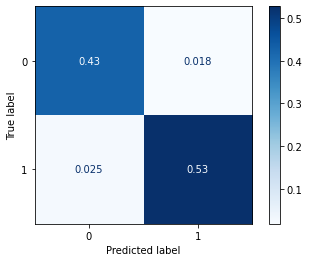

In [ ]:
params_rf = {}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

### Einfache Verbesserung

Hier wird versucht die Modellgenauigkeit durch das Standardisieren der Trainingsdaten zu Verbessern. Leider ohne Erfolg...

In [ ]:
# Normalizing Features - doesn't lead to improvement
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Time taken = 10.317 seconds
ROC_AUC = 0.9563941637037813
              precision    recall  f1-score   support

           0    0.94473   0.95817   0.95140      9205
           1    0.96574   0.95461   0.96015     11369

    accuracy                        0.95621     20574
   macro avg    0.95524   0.95639   0.95578     20574
weighted avg    0.95634   0.95621   0.95623     20574



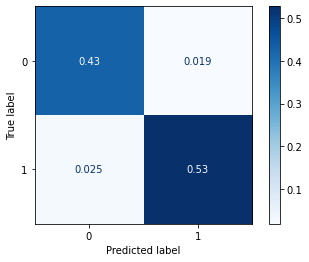

In [ ]:
params_rf = {}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

###Hyperparameter-Optimierung (Bayesian)

Installiere Paket für *Bayesian Optimization*. Anschließend setzen wir die Grenzen der Hyperparametersuche und führen anschließend die Optimierung mit Kreuzvalidierung durch. Die Ergebnisse werden in einer JSON-Datei geloggt. Aufgrund der langen Rechendauer wurde die Optimierung in zwei Sitzungen durchgeführt.

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=bb3ff9b0d3b94ae3276446873e69c2a2e99792445083fc5211e949ff70a84d67
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
from bayes_opt.util import load_logs
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from sklearn.model_selection import cross_val_score

In [ ]:
def rfc_cv(max_depth, min_samples_leaf, n_estimators, min_samples_split, max_features, data, targets):
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_depth=max_depth,
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='roc_auc', cv=4)
    return cval.mean()

In [ ]:
def optimize_rfc(data, targets):
    
    def rfc_crossval(n_estimators, min_samples_split, max_features, max_depth, min_samples_leaf):
        
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_depth=int(max_depth),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (500, 2000),
            "min_samples_split": (2, 25),
            'min_samples_leaf': (1, 5),
            'max_depth': (5, 50),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    # log progress
    logger = JSONLogger(path="./rf_logs_2.json")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

    # New optimizer is loaded with previously seen points
    load_logs(optimizer, logs=["./rf_logs.json"])

    optimizer.maximize(n_iter=30)

    print("Final result:", optimizer.max)

In [ ]:
optimize_rfc(X, y)

Final result: {'target': 0.9935729179112416, 'params': {'max_depth': 49.09908259561231, 'max_features': 0.6610199266260687, 'min_samples_leaf': 2.5233979791812646, 'min_samples_split': 3.740835900525487, 'n_estimators': 511.968794082463}}


### Trainiere neu mit optimierten Hyperparametern

Es werden verschiedene vielversprechende Parameterkonfigurationen aus der JSON verwendet, um Modelle zu trainieren und anschließend zu speichern.

In [ ]:
# Save model
import pickle

Time taken = 441.727 seconds
ROC_AUC = 0.9579123003752115
              precision    recall  f1-score   support

           0    0.94241   0.96350   0.95284      9205
           1    0.96990   0.95233   0.96103     11369

    accuracy                        0.95732     20574
   macro avg    0.95615   0.95791   0.95693     20574
weighted avg    0.95760   0.95732   0.95737     20574



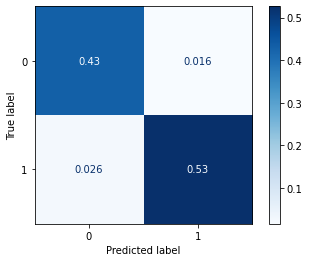

In [ ]:
#rf_v1
params_rf = {'max_depth': 21,
             'max_features': 0.653,
         'min_samples_leaf': 1,
         'min_samples_split': 10,
         'n_estimators': 1900,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

filename = 'export/rf_v1'
pickle.dump(model_rf, open(filename, 'wb'))

Time taken = 147.525 seconds
ROC_AUC = 0.9585797050777367
              precision    recall  f1-score   support

           0    0.94334   0.96404   0.95358      9205
           1    0.97036   0.95312   0.96166     11369

    accuracy                        0.95801     20574
   macro avg    0.95685   0.95858   0.95762     20574
weighted avg    0.95827   0.95801   0.95804     20574



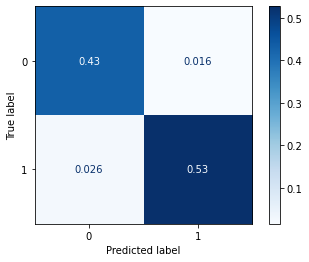

In [ ]:
#rf_v2
params_rf = {'max_depth': 49,
             'max_features': 0.661,
         'min_samples_leaf': 3,
         'min_samples_split': 4,
         'n_estimators': 512,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

filename = 'export/rf_v2'
pickle.dump(model_rf, open(filename, 'wb'))

Time taken = 285.14 seconds
ROC_AUC = 0.9579666186804804
              precision    recall  f1-score   support

           0    0.94241   0.96361   0.95289      9205
           1    0.96999   0.95233   0.96108     11369

    accuracy                        0.95737     20574
   macro avg    0.95620   0.95797   0.95698     20574
weighted avg    0.95765   0.95737   0.95741     20574



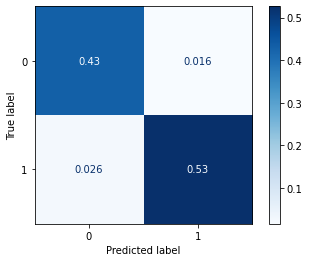

In [ ]:
#rf_v3
params_rf = {'max_depth': 48,
             'max_features': 0.61264,
         'min_samples_leaf': 4,
         'min_samples_split': 2,
         'n_estimators': 1020,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

filename = 'export/rf_v3'
pickle.dump(model_rf, open(filename, 'wb'))

Time taken = 105.578 seconds
ROC_AUC = 0.957858134958127
              precision    recall  f1-score   support

           0    0.94441   0.96154   0.95290      9205
           1    0.96840   0.95417   0.96123     11369

    accuracy                        0.95747     20574
   macro avg    0.95640   0.95786   0.95707     20574
weighted avg    0.95767   0.95747   0.95750     20574



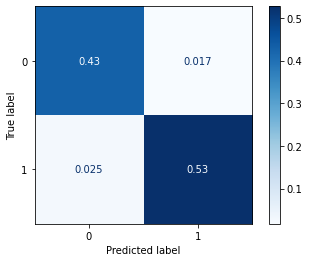

In [ ]:
#rf_v4
params_rf = {'max_depth': 48,
             'max_features': 0.3577,
         'min_samples_leaf': 2,
         'min_samples_split': 7,
         'n_estimators': 679,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

filename = 'export/rf_v4'
pickle.dump(model_rf, open(filename, 'wb'))

Time taken = 326.83 seconds
ROC_AUC = 0.9577286673324629
              precision    recall  f1-score   support

           0    0.94258   0.96295   0.95266      9205
           1    0.96947   0.95250   0.96091     11369

    accuracy                        0.95718     20574
   macro avg    0.95602   0.95773   0.95678     20574
weighted avg    0.95744   0.95718   0.95722     20574



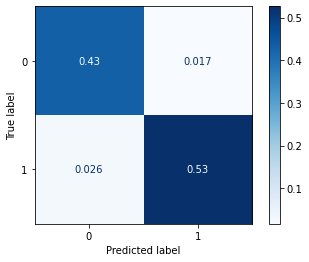

In [ ]:
#rf_v5
params_rf = {'max_depth': 50,
             'max_features': 0.6319,
         'min_samples_leaf': 4,
         'min_samples_split': 4,
         'n_estimators': 1295,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_val, y_val)

filename = 'export/rf_v5'
pickle.dump(model_rf, open(filename, 'wb'))

## Modellevaluation

Lade Testset und berechne anschließend für all trainierten Modelle Genauigkeit und Fbeta(0,5)-Wert.

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
y_test = test['satisfaction']
X_test = test[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]# Normalizing Features

In [ ]:
# Calculate Accuracy - v1
filename = 'export/rf_v1'
model_rf = pickle.load(open(filename, 'rb'))

result = model_rf.score(X_test, y_test)
print(result)

0.9580433176498037


In [ ]:
# Calculate Fbeta - v1
y_pred = model_rf.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9672711062538647


In [ ]:
# Calculate Accuracy - v2
filename = 'export/rf_v2'
model_rf = pickle.load(open(filename, 'rb'))

result = model_rf.score(X_test, y_test)
print(result)

0.9575378154528134


In [ ]:
# Calculate Fbeta - v2
y_pred = model_rf.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9666269025683777


In [ ]:
# Calculate Accuracy - v3
filename = 'export/rf_v3'
model_rf = pickle.load(open(filename, 'rb'))

result = model_rf.score(X_test, y_test)
print(result)

0.9571489676089746


In [ ]:
# Calculate Fbeta - v3
y_pred = model_rf.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9661499116392007


Modell 4 und 5 wurden mit standardisierten Daten trainiert, daher müssen die Testdaten vor der Evaluation hier ebenfalls standardisiert werden.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [ ]:
# Calculate Accuracy - v4 - with normalisation
filename = 'export/rf_v4'
model_rf = pickle.load(open(filename, 'rb'))

result = model_rf.score(X_test, y_test)
print(result)

0.9577322393747326


In [ ]:
# Calculate Fbeta - v4
y_pred = model_rf.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.966237642230927


In [ ]:
# Calculate Accuracy - v5 - with normalisation
filename = 'export/rf_v5'
model_rf = pickle.load(open(filename, 'rb'))

result = model_rf.score(X_test, y_test)
print(result)

0.9571489676089746


In [ ]:
# Calculate Fbeta - v5
y_pred = model_rf.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.9661499116392007


## SHAP

Installiere/lade SHAP-Tool, lade bestes Modell und ggf. noch einmal die Testdaten:

In [ ]:
!pip install shap
import shap
import pickle
import matplotlib.pyplot as plt

     |████████████████████████████████| 327kB 3.2MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456461 sha256=c3db90e2ed706d4e8322300a796e7e8dfbb6d322a12412bd0a92628ac071aaa0
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
filename = 'export/rf_v1'
model_rf = pickle.load(open(filename, 'rb'))

In [ ]:
test = pd.read_csv('data/test_set.csv')
y_test = test['satisfaction']
X_test = test[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

Erstelle Tree Explainer:

In [ ]:
explainer = shap.TreeExplainer(model_rf)

####Lokale Interpretationen

Hier werden einige einzelne Vorhersagen interpretierbar gemacht.

In [ ]:
choosen_instance = X_test.loc[[421]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = X_test.loc[[1500]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = X_test.loc[[3000]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = X_test.loc[[18000]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

####Globale Interpretationen

Da die Berechnung der SHAP-Werte für das gesamte Testset zu zeit- und rechenintensiv ist, wird ein Teildatensatz mit 2% der ursprünglichen Größe dem Testset entnommen. Verwende *random_state* für Reproduzierbarkeit.

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
# Select random Subset of Testset to accelerate calculation
test_sub = test.sample(frac=0.02, random_state=32)
test_sub.shape

(514, 23)

In [ ]:
y_test_sub = test_sub['satisfaction']
X_test_sub = test_sub[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

In [ ]:
shap_values_RF_test = explainer.shap_values(X_test_sub)

In [ ]:
df_shap_RF_test_1 = pd.DataFrame(shap_values_RF_test[0], columns=X_test_sub.columns.values)

In [ ]:
df_shap_RF_test_1

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,-0.016638,-0.059544,-0.001383,-0.014700,-0.038575,0.000918,-0.036350,-0.009365,-0.002753,0.033615,-0.002701,-0.091200,-0.038375,-0.050740,-0.026487,-0.022317,-0.020711,-0.030475,-0.020148,-0.004482,-0.001391,0.001273
1,0.029114,-0.025233,-0.020968,-0.037743,0.007569,-0.010512,-0.058474,-0.002594,-0.008624,-0.008517,-0.004671,-0.125491,0.067864,-0.062770,0.014028,0.020897,-0.024246,0.038935,0.006063,-0.006246,-0.007940,-0.017565
2,-0.076815,-0.036077,0.001319,0.034396,0.009061,-0.038837,0.001675,-0.051833,0.013946,0.006385,-0.001112,-0.120359,-0.030424,-0.057656,-0.020806,-0.023519,-0.015811,-0.021900,-0.015243,-0.007999,0.001066,0.005739
3,-0.011264,-0.021876,-0.002344,-0.018322,-0.014237,-0.000067,-0.248543,0.024874,-0.007835,0.012727,0.001515,-0.056651,-0.048388,-0.002136,0.012706,-0.003793,0.014849,-0.050848,0.013628,-0.041026,-0.001907,-0.003588
4,0.037936,-0.039035,-0.003004,-0.042498,-0.064794,-0.030628,-0.047485,-0.003511,-0.001290,0.041971,0.002700,-0.167228,-0.048623,-0.048067,-0.021869,-0.019710,0.001072,-0.000104,0.000854,-0.003583,0.000619,0.003797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.019601,0.245383,-0.024289,-0.030294,-0.066085,-0.006555,0.099179,-0.009069,0.005930,0.010928,0.001295,0.207734,-0.030916,0.002213,0.009504,0.029999,-0.002068,-0.033982,-0.000919,-0.039787,-0.001127,-0.002165
510,0.021065,-0.018997,-0.004554,-0.009271,0.018838,0.006135,0.103442,0.013888,-0.015084,0.015572,0.002626,0.192645,0.022047,0.078157,0.033942,-0.006665,0.020422,0.015097,0.028472,0.017172,-0.001769,-0.004450
511,0.014402,0.070907,0.001600,-0.022170,0.018006,-0.000338,-0.377024,0.011217,-0.021610,0.002935,0.002948,-0.138898,0.013704,0.026172,-0.017001,-0.000561,0.008643,-0.029908,-0.021145,0.010741,-0.001844,-0.003303
512,-0.023066,-0.053762,0.003005,-0.021479,-0.025487,0.001300,0.007905,-0.010188,-0.005492,0.005469,0.016424,-0.249783,-0.110000,-0.003575,0.014100,0.010330,0.008424,-0.003635,0.006592,-0.011376,-0.001642,-0.002988


Hier werden globale Interpretationen mehrerer Vorhersagen ermöglicht. Zuerst wird für jede Variable ein *Dependence plot* gezeichnet, bei denen auf der x-Achse der Wert der Variable, auf der y-Achse der SHAP-Wert und durch die Färbung die am stärksten interagierende andere Variable illustriert wird. 

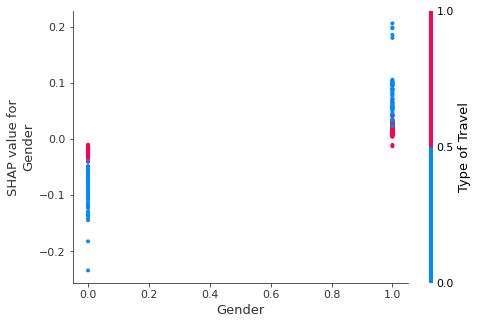

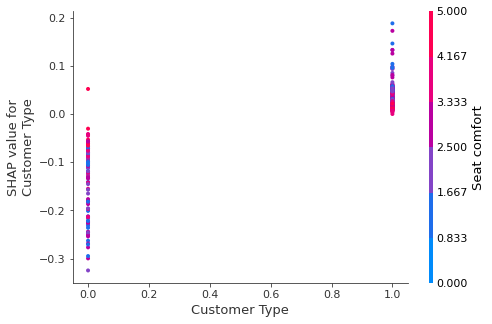

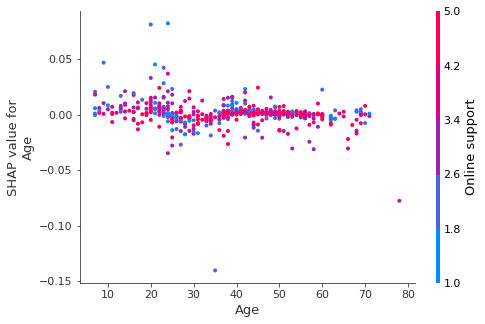

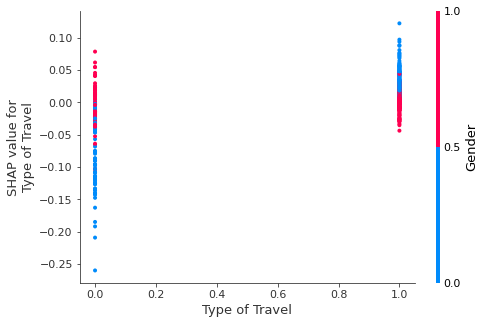

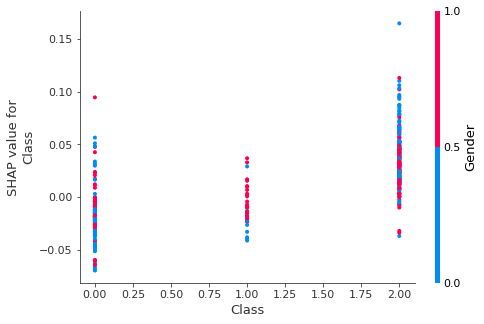

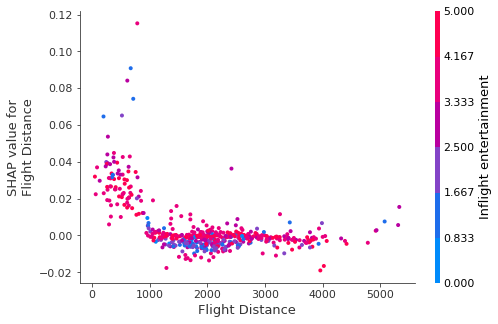

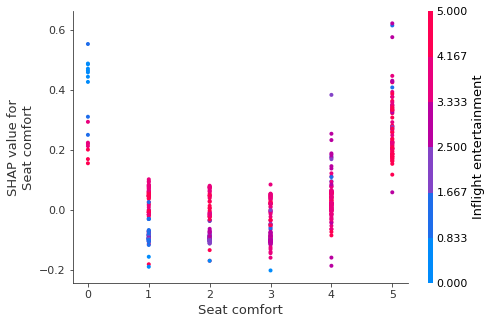

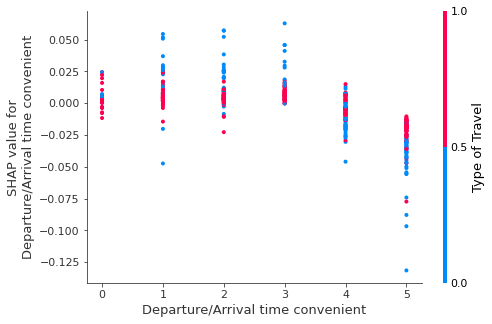

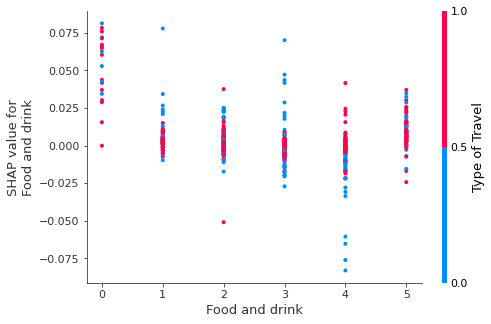

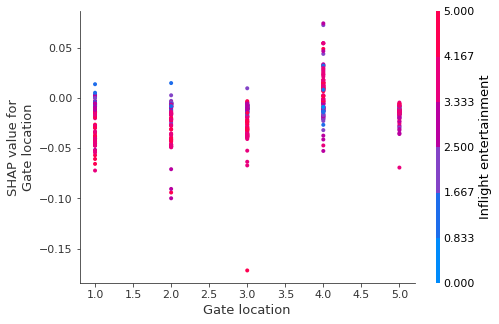

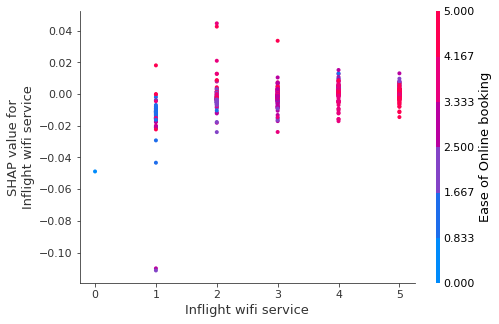

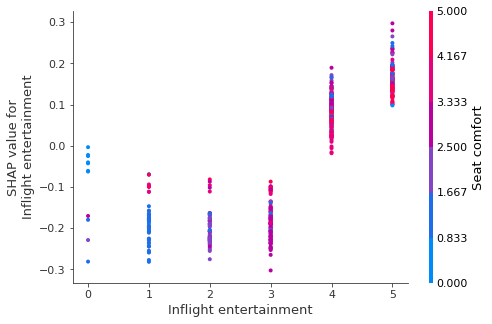

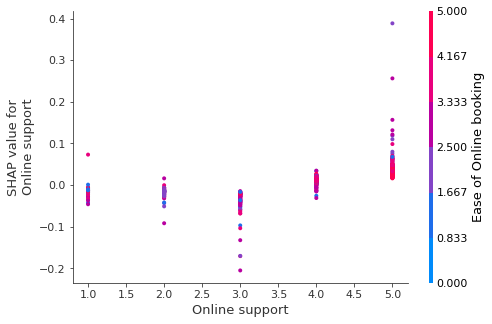

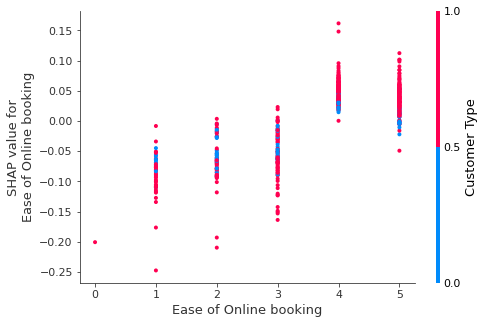

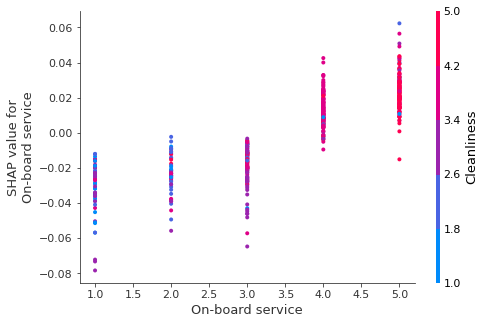

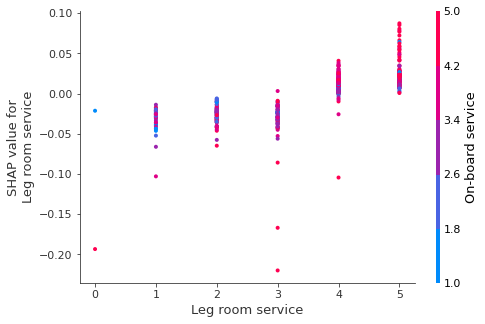

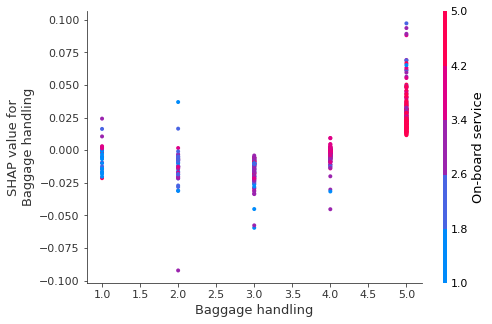

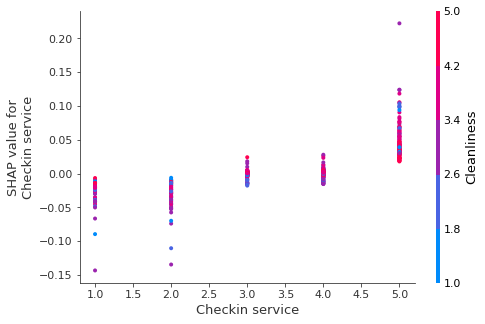

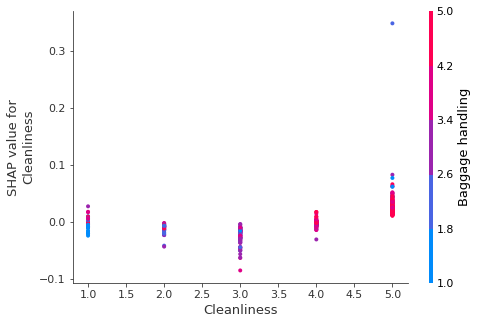

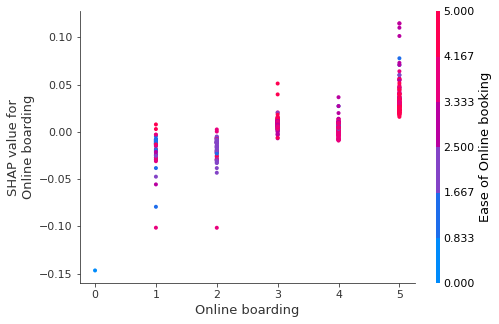

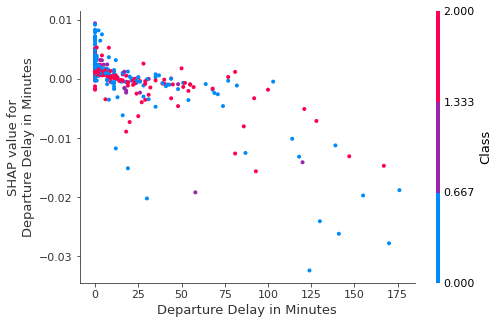

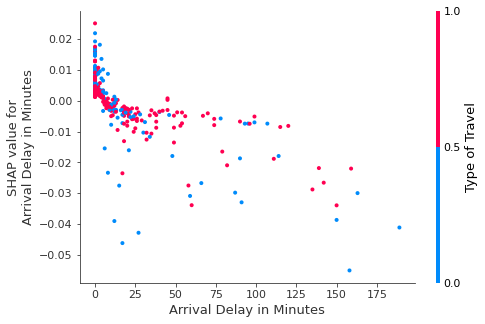

In [ ]:
for name in X_test_sub.columns:
    shap.dependence_plot(name, shap_values_RF_test[1], X_test_sub)

In den beiden *Summary plots* sind die Variablen von oben nach unten absteigend nach ihrem durschnittlichen Einfluss auf die Vorhersage geordnet. Im ersten Schaubild ist zudem die Verteilung der SHAP-Werte pro Variable in Abhängigkeit von den Variablenwerten der Fluggäste ablesbar.

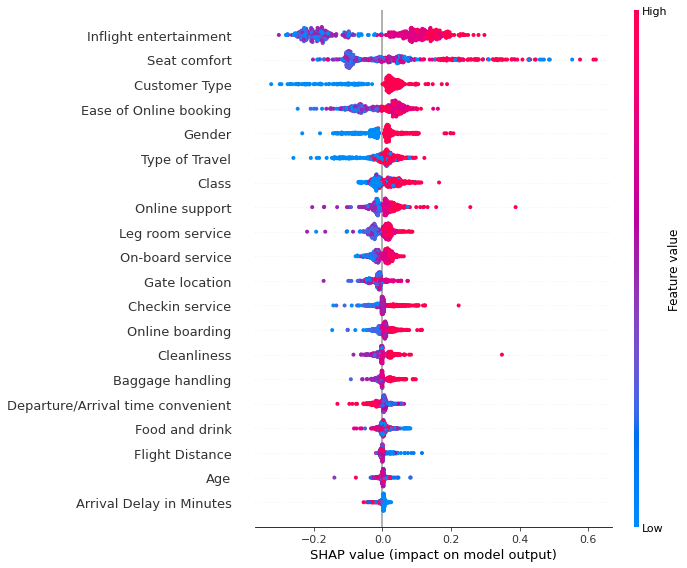

In [ ]:
shap.summary_plot(shap_values_RF_test[1], X_test_sub)

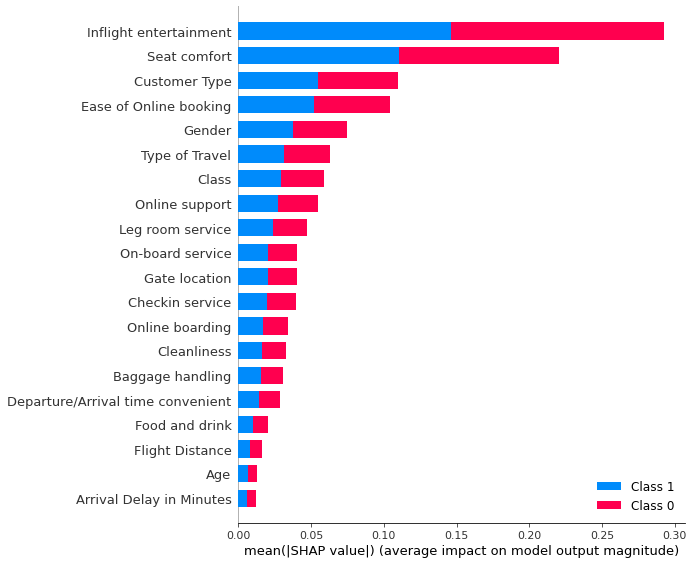

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_RF_test, X_test_sub, plot_type="bar")

Die letzte Grafik zeigt die Einflüsse der Variablen auf die Vorhersagen für alle 513 Einträge des Teildatensatzes. Dabei sind die Beobachtungen nach ihrer Ähnlichkeit geordnet.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_RF_test[1], X_test_sub)